In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.pca_translation_utils import *


warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
transform = Reshape2DField()

cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform)
vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform)
runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
sqh_info = get_pca_results(sqh_dataset)
cad_info = get_pca_results(cad_dataset)
vel_info = get_pca_results(vel_dataset)
runt_info = get_pca_results(runt_dataset)

100%|██████████| 6/6 [00:00<00:00, 270.57it/s]


Found PCA for this dataset!
Found PCA for this dataset!
Found PCA for this dataset!
Found PCA for this dataset!


# Figure 1 - Tissue Velocity is Sparse

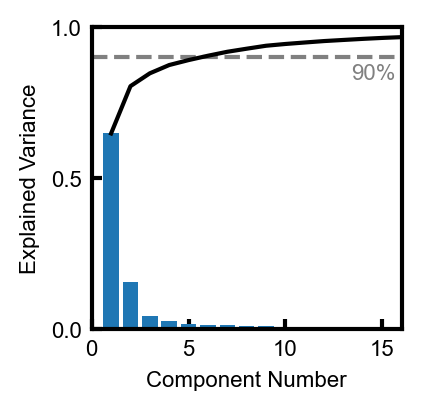

In [34]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

model, df = vel_info

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

cpt = np.arange(model.n_components_) + 1
ax.plot(cpt, np.cumsum(model.explained_variance_ratio_), color='black')
ax.bar(cpt, model.explained_variance_ratio_, zorder=2)
ax.set(xlim=[np.min(cpt)-0.5, np.max(cpt)], xticks=[0, 5, 10, 15],
       xlabel='Component Number',
       ylim=[0, 1], yticks=[0, 0.5, 1],
       ylabel='Explained Variance')
ax.axhline(0.9, color='grey', linestyle='--', zorder=0)
ax.text(0.98, 0.88, '90%', transform=ax.transAxes,
        color='grey', va='top', ha='right')

plt.savefig('Figures/velocity_sparsity.svg', bbox_inches='tight')

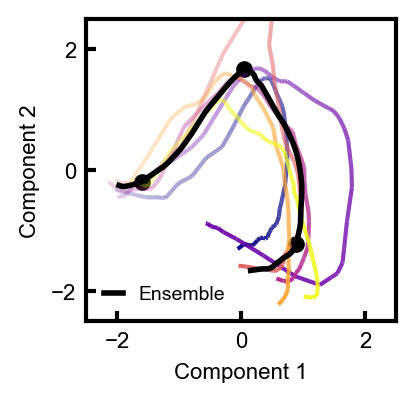

In [180]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7

model, df = vel_info
tmin, tmax = 15, 60
df = vel_info[1].copy()
df = df[(df.t >= tmin) & (df.t <= tmax)]
offset = 10

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))
for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    
    c = np.repeat(colors[i][None], len(data), axis=0)
    array = (data.t.values +offset- np.min(data.t)) / (np.ptp(data.t)+offset)
    c[:, -1] = array
    p0 = data.param0.values - np.mean(df.param0)
    p1 = data.param1.values - np.mean(df.param1)
    points = np.vstack((p0, p1)).T.reshape([-1, 1, 2])
    segs = np.hstack((points[:-1], points[1:]))
    lc = LineCollection(segs, colors=c)
    ax.add_collection(lc)

from scipy.interpolate import interp1d
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0 - data.param0.mean(), fill_value='extrapolate')
p1 = interp1d(data.t, data.param1 - data.param1.mean(), fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')
t = [20, 31, 50]
ax.scatter(p0(t), p1(t), s=25, color='black')

ax.set(xlim=[-2.5, 2.5], xticks=[-2, 0, 2],
       ylim=[-2.5, 2.5], yticks=[-2, 0, 2],
       xlabel='Component 1',
       ylabel='Component 2')
ax.legend(loc='lower left')

plt.savefig('Figures/velocity_pca_trajectory.svg', bbox_inches='tight')

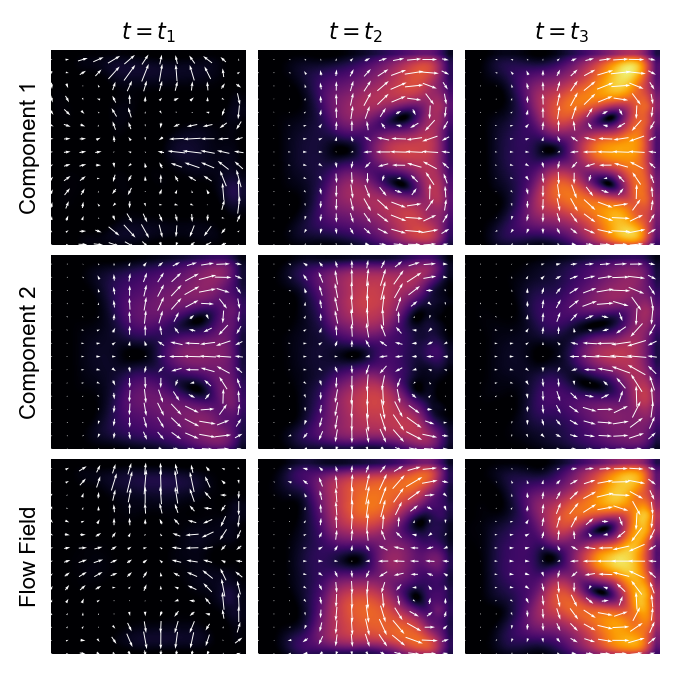

In [233]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 0.

model, df = vel_info
tmin, tmax = 15, 60
df = vel_info[1].copy()
df = df[(df.t >= tmin) & (df.t <= tmax)]
offset = 10

fig, ax = plt.subplots(3, 3, figsize=(4, 4))

from scipy.interpolate import interp1d
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0)
p1 = interp1d(data.t, data.param1)
t = [20, 31, 50]

vmin = df.mag.min()
vmax = 2*df.mag.max()
kwargs = dict(skip=16, vmin=vmin, vmax=vmax)

for i in range(len(t)):
    vec = np.zeros([1, model.n_components])
    vec[:, 0] = p0(t[i])
    z = model.inverse_transform(vec).reshape([2, 236, 200])
    plot_vector2D(ax[0, i], z, **kwargs)
    
    vec = np.zeros_like(vec)
    vec[:, 1] = p1(t[i])
    z = model.inverse_transform(vec).reshape([2, 236, 200])
    plot_vector2D(ax[1, i], z, **kwargs)
    
    row = (data.t - t[i]).abs().argmin()
    row = data.iloc[row].filter(like='param').values
    z = model.inverse_transform(row[None]).reshape([2, 236, 200])
    plot_vector2D(ax[2, i], z, **kwargs)


for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_xlim()) / np.ptp(a.get_ylim()))
        
for i in range(3):
    ax[0, i].set_xlabel('$t = t_%d$' % (i+1))
    ax[0, i].xaxis.set_label_position('top')
    
    ax[i, 0].set_ylabel('Component %d' % (i+1))
                        
ax[-1, 0].set_ylabel('Flow Field')  

fig.subplots_adjust(wspace=0.0, hspace=0.05)

plt.savefig('Figures/velocity_component_points.svg', bbox_inches='tight')

# Figure 2 - A search for sparsity

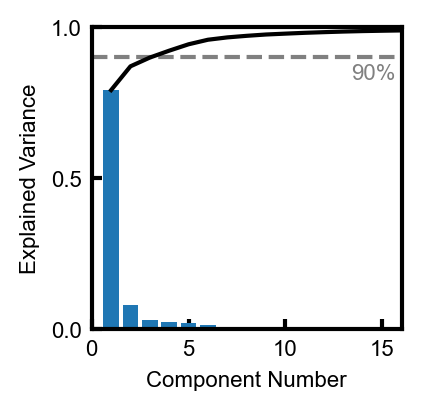

In [234]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

model, df = cad_info

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

cpt = np.arange(model.n_components_) + 1
ax.plot(cpt, np.cumsum(model.explained_variance_ratio_), color='black')
ax.bar(cpt, model.explained_variance_ratio_, zorder=2)
ax.set(xlim=[np.min(cpt)-0.5, np.max(cpt)], xticks=[0, 5, 10, 15],
       xlabel='Component Number',
       ylim=[0, 1], yticks=[0, 0.5, 1],
       ylabel='Explained Variance')
ax.axhline(0.9, color='grey', linestyle='--', zorder=0)
ax.text(0.98, 0.88, '90%', transform=ax.transAxes,
        color='grey', va='top', ha='right')

plt.savefig('Figures/cadherin_sparsity.svg', bbox_inches='tight')

Bad:  [202001282000]


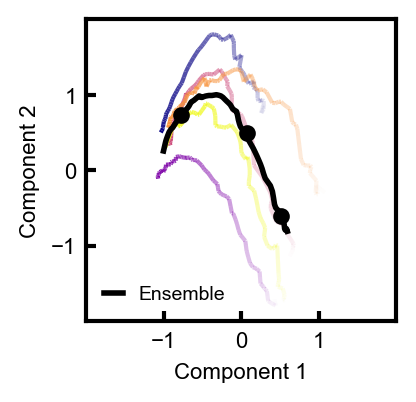

In [312]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7

model, df = cad_info
tmin, tmax = 15, 60
df = cad_info[1].copy()
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

from scipy.interpolate import interp1d
from scipy.signal import convolve

bad = []
for embryoID in df.embryoID.unique():
    if df[df.embryoID == embryoID].param1.max() > 2:
        bad.append(embryoID)
print('Bad: ', bad)
df = df[~df.embryoID.isin(bad)]
df.param0 -= (np.max(df.param0) + np.min(df.param0)) / 2
df.param1 -= (np.max(df.param1) + np.min(df.param1)) / 2

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    
    t0 = (data.t.values - np.min(data.t)) / np.ptp(data.t)
    t = np.linspace(0, 1, 100)
    
    p0 = interp1d(t0, data.param0.values)(t)
    p1 = interp1d(t0, data.param1.values)(t)

    points = np.vstack((p0, p1)).T.reshape([-1, 1, 2])
    segs = np.hstack((points[:-1], points[1:]))
                          
    c = np.repeat(colors[i][None], len(segs), axis=0)
    c[:, -1] = t[1:]

    lc = LineCollection(segs, colors=c)
    ax.add_collection(lc)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')
t = [20, 31, 50]
ax.scatter(p0(t), p1(t), s=25, color='black', zorder=10)

ax.set(xlim=[-2, 2], xticks=[-1, 0, 1],
       ylim=[-2, 2], yticks=[-1, 0, 1],
       xlabel='Component 1',
       ylabel='Component 2')
ax.legend(loc='lower left')

plt.savefig('Figures/cadherin_pca_trajectory.svg', bbox_inches='tight')

Bad:  [202001282000]


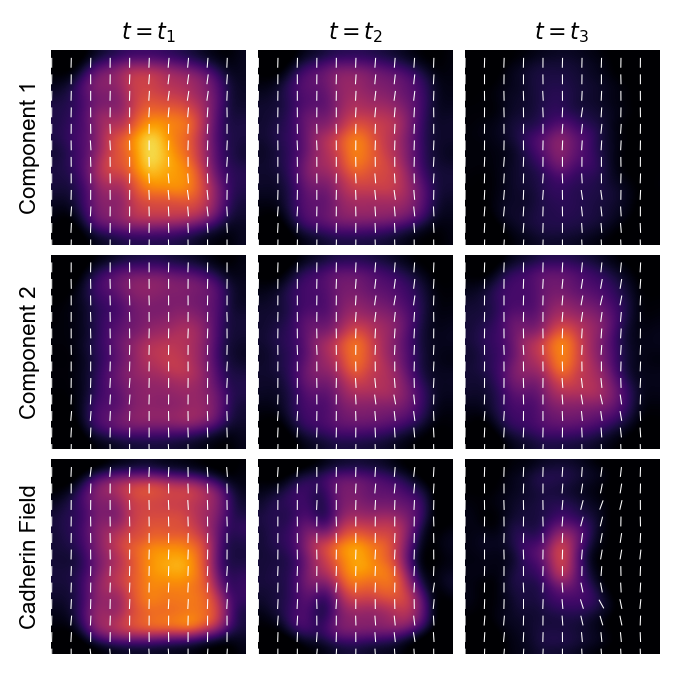

In [345]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 0.


model, df = cad_info
tmin, tmax = 15, 60
df = cad_info[1].copy()
df = df[(df.t >= tmin) & (df.t <= tmax)]

from scipy.interpolate import interp1d
from scipy.signal import convolve

bad = []
for embryoID in df.embryoID.unique():
    if df[df.embryoID == embryoID].param1.max() > 2:
        bad.append(embryoID)
print('Bad: ', bad)
df = df[~df.embryoID.isin(bad)]

fig, ax = plt.subplots(3, 3, figsize=(4, 4))

from scipy.interpolate import interp1d
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0)
p1 = interp1d(data.t, data.param1)
t = [20, 31, 50]

vmin = df.mag.min()
vmax = 1.75*df.mag.max()
kwargs = dict(skip=20, vmin=vmin, vmax=vmax)

for i in range(len(t)):
    vec = np.zeros([1, model.n_components])
    vec[:, 0] = p0(t[i])
    z = model.inverse_transform(vec).reshape([4, 236, 200])
    plot_tensor2D(ax[0, i], z, **kwargs)
    
    vec = np.zeros_like(vec)
    vec[:, 1] = p1(t[i])
    z = model.inverse_transform(vec).reshape([4, 236, 200])
    plot_tensor2D(ax[1, i], z, **kwargs)
    
    row = (data.t - t[i]).abs().argmin()
    row = data.iloc[row].filter(like='param').values
    z = model.inverse_transform(row[None]).reshape([4, 236, 200])
    plot_tensor2D(ax[2, i], z, **kwargs)


for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_xlim()) / np.ptp(a.get_ylim()))
        
for i in range(3):
    ax[0, i].set_xlabel('$t = t_%d$' % (i+1))
    ax[0, i].xaxis.set_label_position('top')
    
    ax[i, 0].set_ylabel('Component %d' % (i+1))
                        
ax[-1, 0].set_ylabel('Cadherin Field')  

fig.subplots_adjust(wspace=0.0, hspace=0.05)

plt.savefig('Figures/cadherin_component_points.svg', bbox_inches='tight')

0 -0.9392308356200627 -1.3711055911302727
1 -0.2581472009833393 -1.3711055911302727
2 0.42293643365338407 -1.3711055911302727
3 1.1040200682901076 -1.3711055911302727
4 -0.9392308356200627 -0.5636452511754335
5 -0.2581472009833393 -0.5636452511754335
6 0.42293643365338407 -0.5636452511754335
7 1.1040200682901076 -0.5636452511754335
8 -0.9392308356200627 0.24381508877940572
9 -0.2581472009833393 0.24381508877940572
10 0.42293643365338407 0.24381508877940572
11 1.1040200682901076 0.24381508877940572
12 -0.9392308356200627 1.051275428734245
13 -0.2581472009833393 1.051275428734245
14 0.42293643365338407 1.051275428734245
15 1.1040200682901076 1.051275428734245


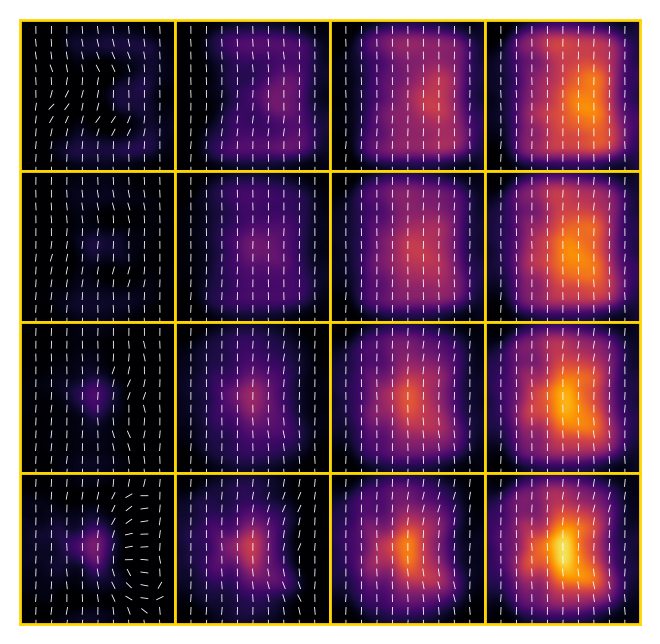

In [346]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = 'gold'


model, df = cad_info

N = 4
fig, ax = plt.subplots(N, N, figsize=(4, 4))

vmin = df.mag.min()
vmax = 1.5*df.mag.max()
kwargs = dict(skip=20, vmin=vmin, vmax=vmax)

r0, r1 = np.percentile(df.param0, [10, 90])
s0, s1 = np.percentile(df.param1, [10, 90])

p0 = np.linspace(0, 1, N) * (r1-r0) + r0
p1 = np.linspace(0, 1, N) * (s1-s0) + s0

p0 = np.repeat(p0[None, :], N, axis=0).flatten()
p1 = np.repeat(p1[:, None], N, axis=1).flatten()

vec = np.zeros([len(p0), model.n_components])
vec[:, 0] = p0
vec[:, 1] = p1
z = model.inverse_transform(vec).reshape([-1, 4, 236, 200])

ax = ax.flatten()
for i in range(len(ax)):
    print(i, p0[i], p1[i])
    plot_tensor2D(ax[i], z[i], **kwargs)
    ax[i].set_aspect('auto')
                            
fig.subplots_adjust(wspace=0.0, hspace=0.)

plt.savefig('Figures/cadherin_component_sweep.svg', bbox_inches='tight')

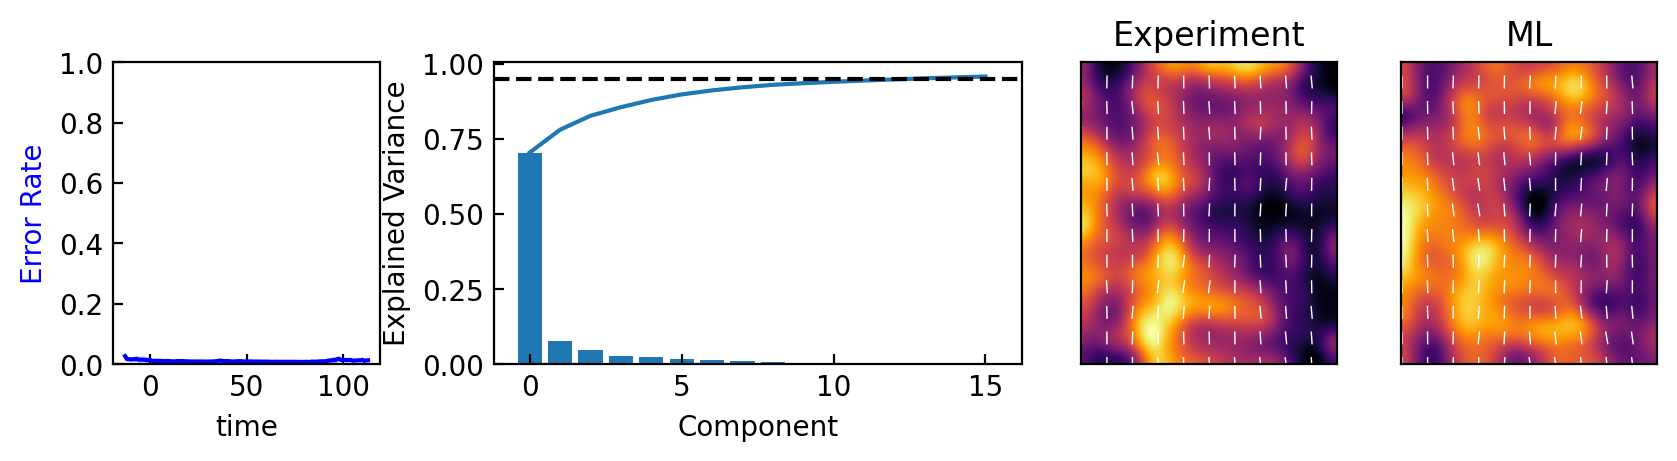

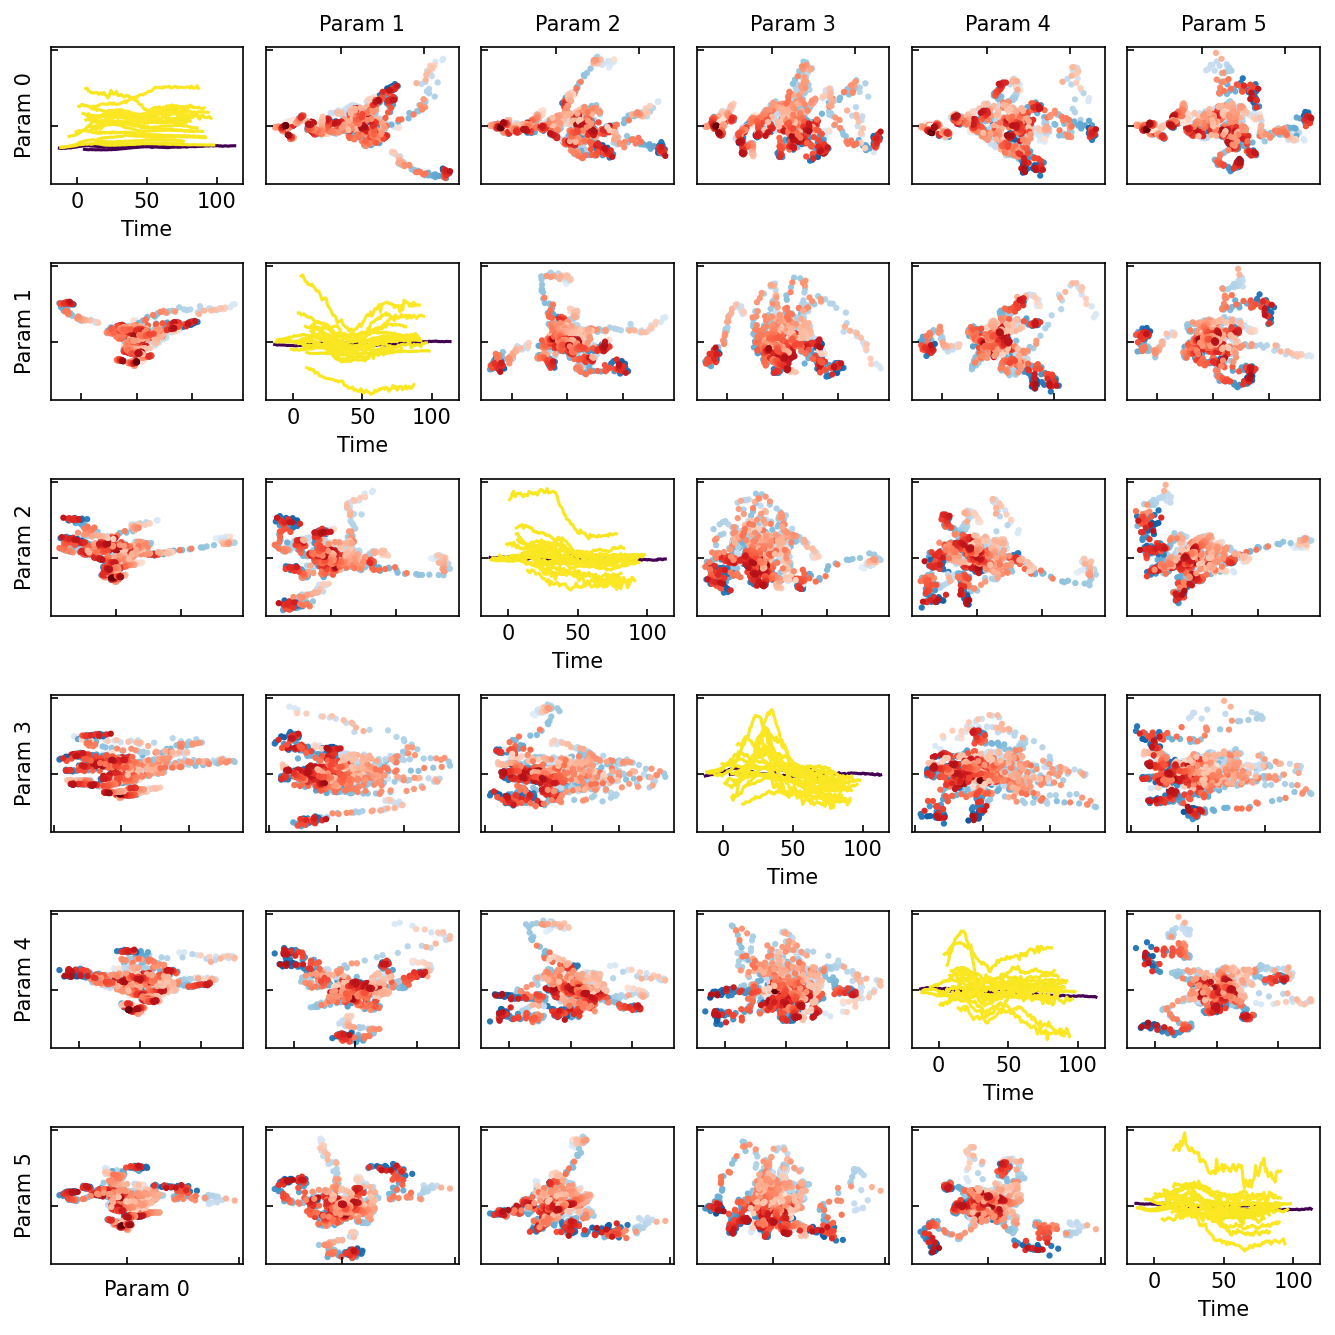

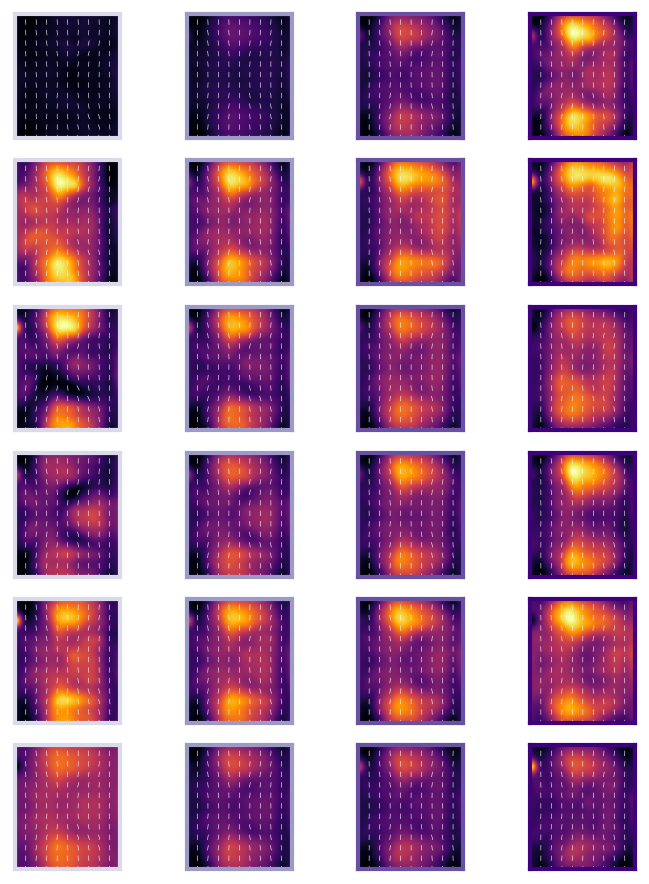

In [ ]:
pca_summary_plot(*sqh_info, sqh_dataset, 5, show_magnitude=False, cutoff=0.95, plot_fn=plot_tensor2D)
pca_point_plot(*sqh_info, cutoff=0.9)
pca_sweep_plot(*sqh_info, cutoff=0.9, plot_fn=plot_tensor2D)

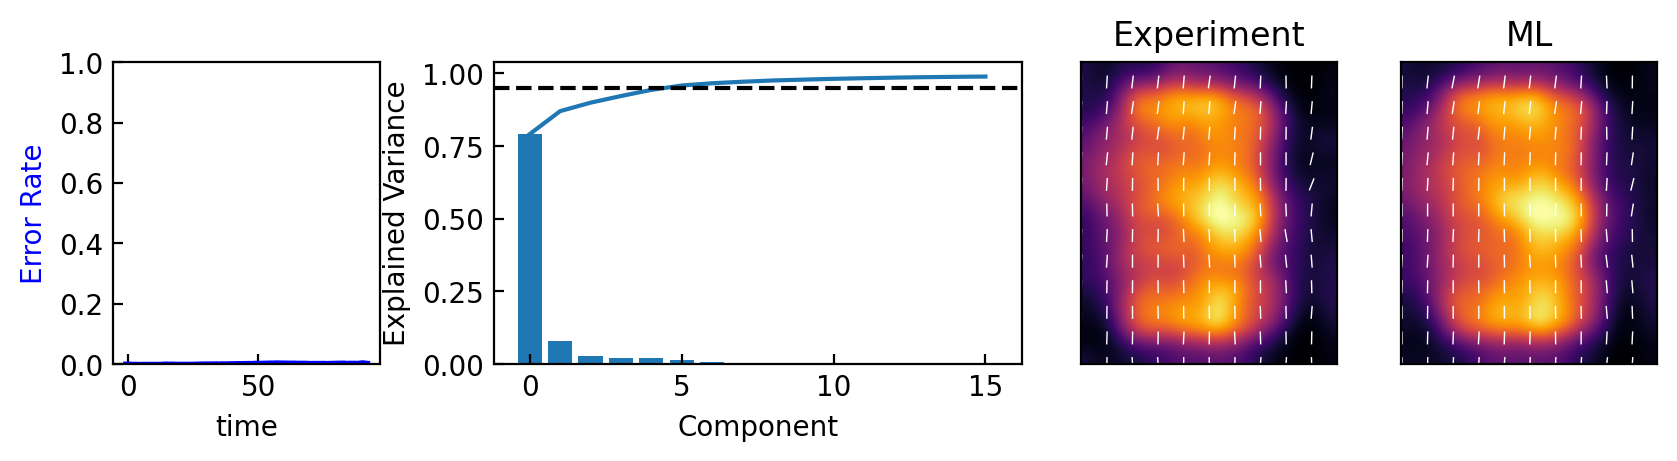

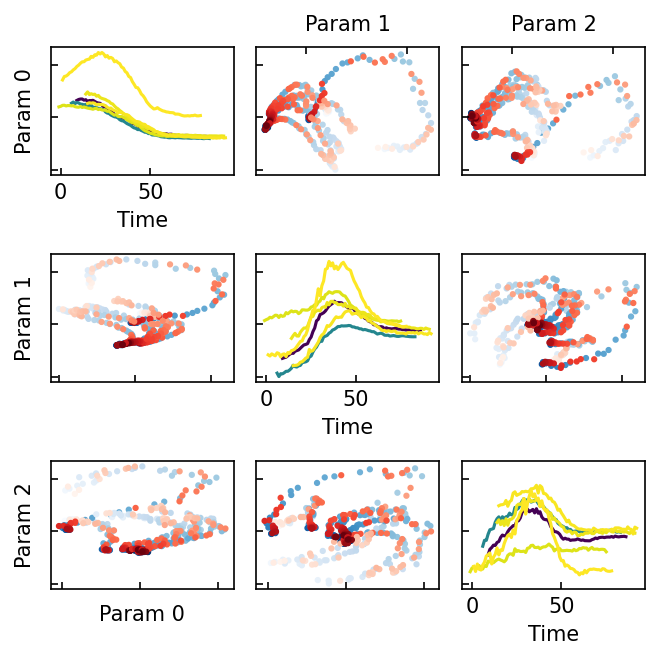

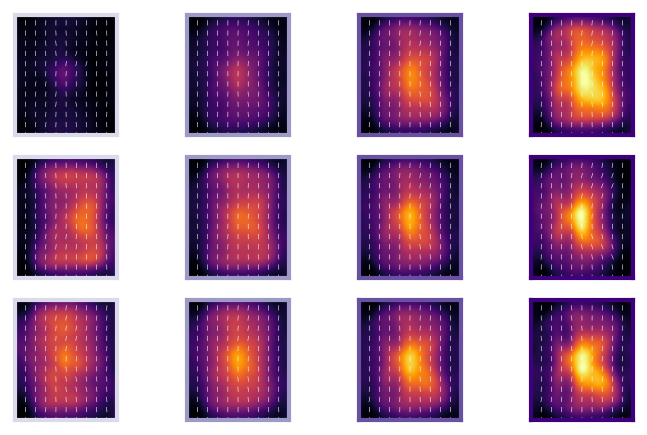

In [10]:
pca_summary_plot(*cad_info, cad_dataset, 5, show_magnitude=False, cutoff=0.95, plot_fn=plot_tensor2D)
pca_point_plot(*cad_info, cutoff=0.9)
pca_sweep_plot(*cad_info, cutoff=0.9, plot_fn=plot_tensor2D)

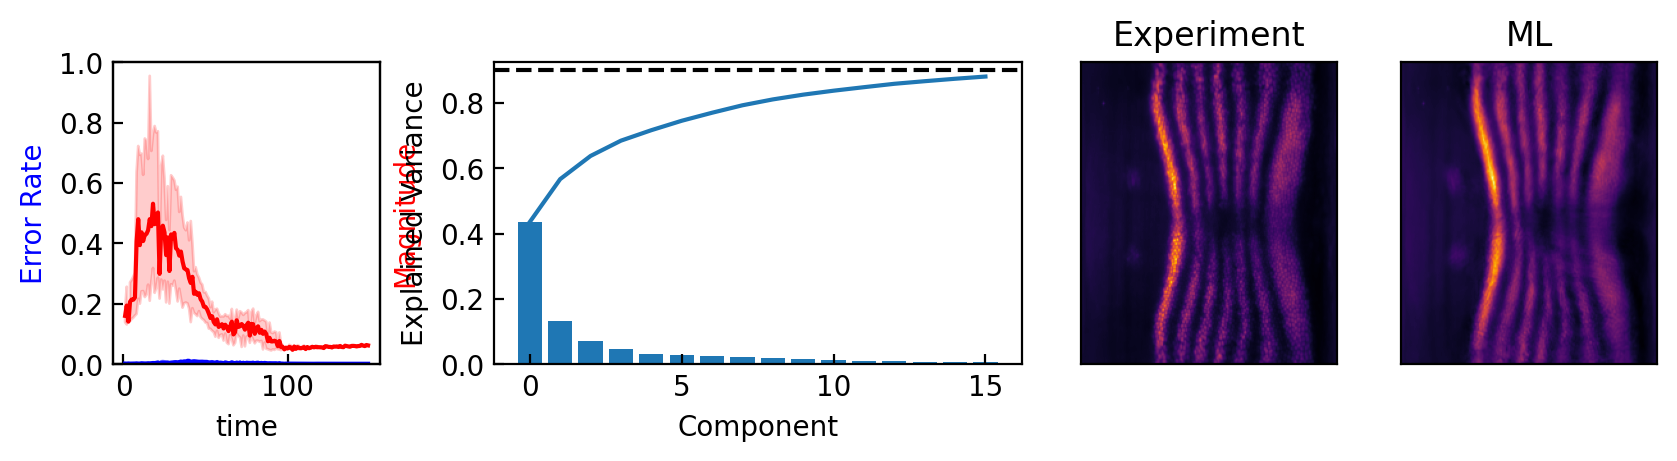

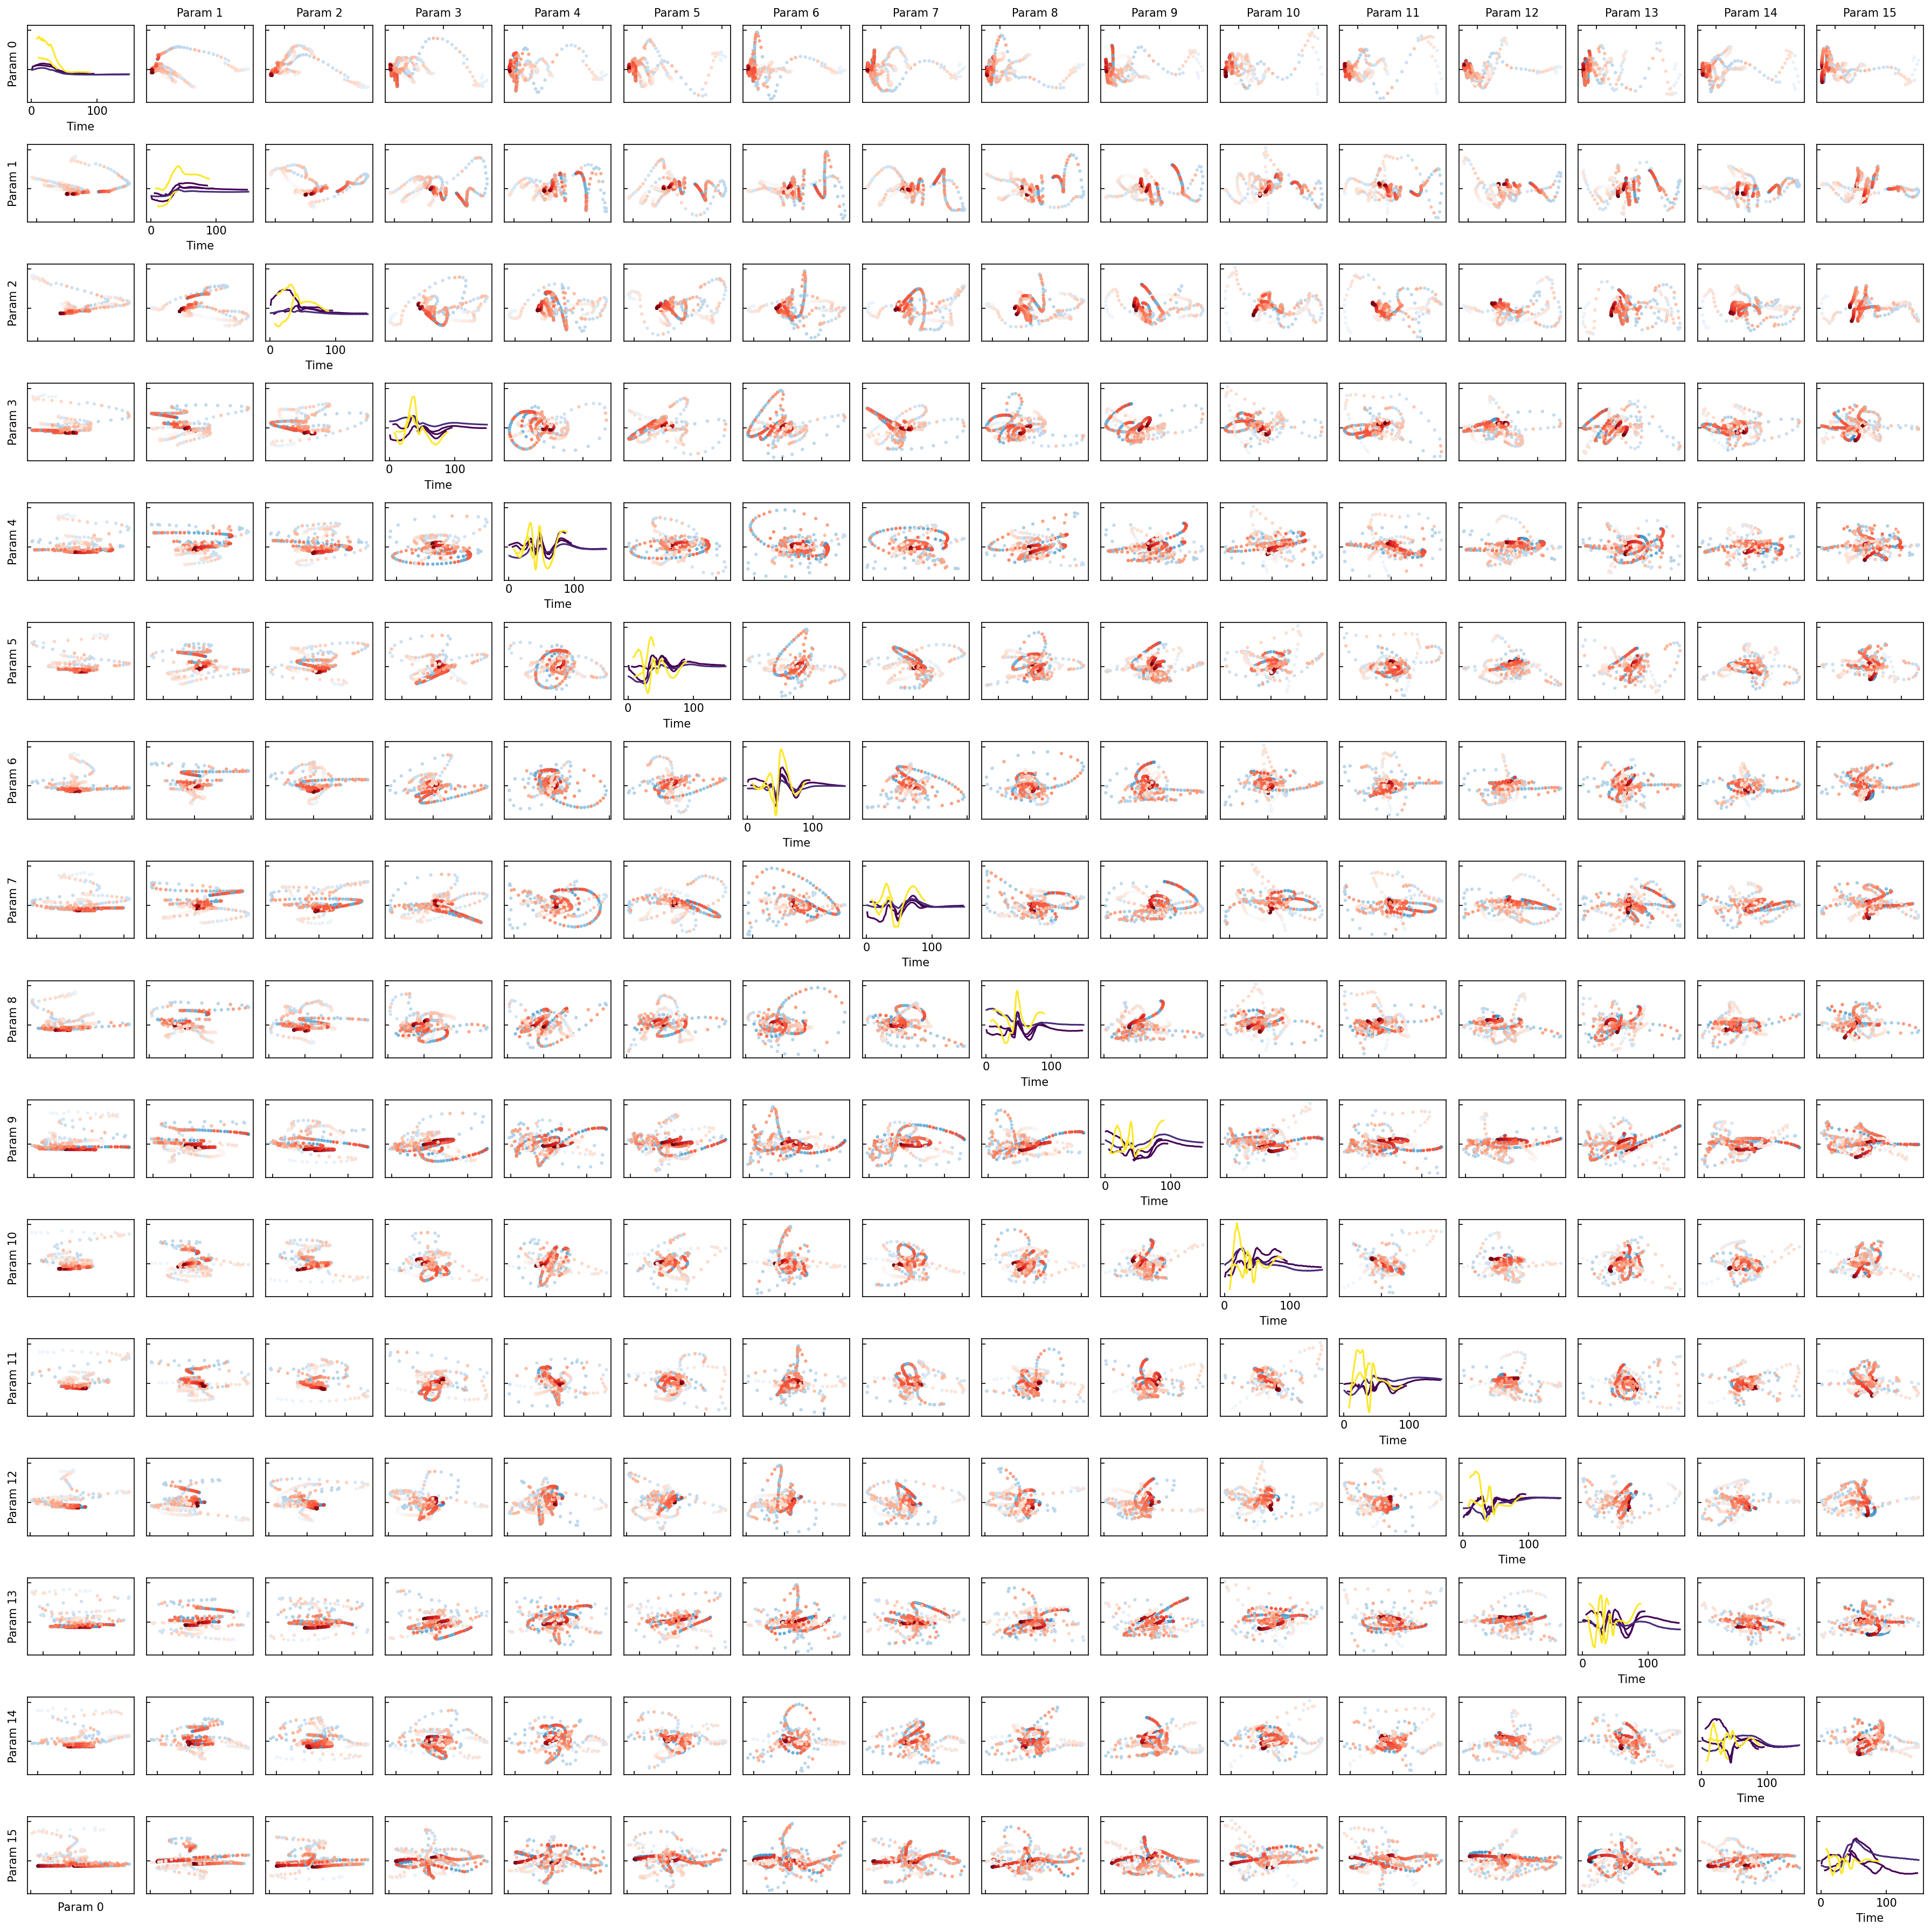

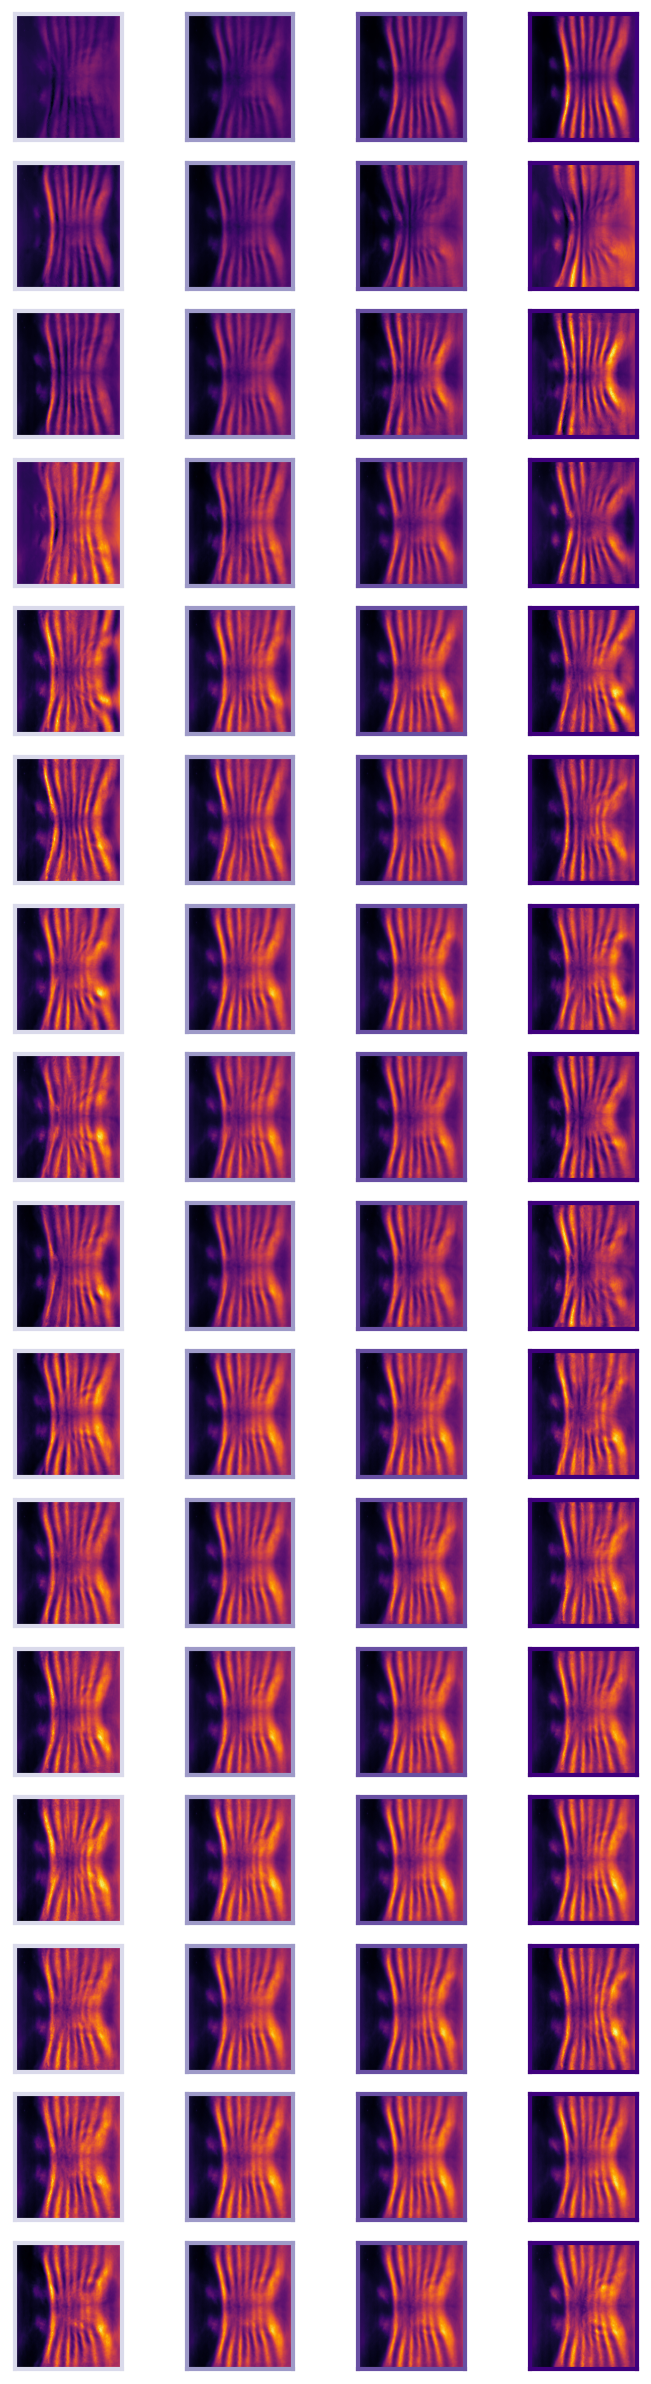

In [12]:
pca_summary_plot(*runt_info, runt_dataset, 5, show_magnitude=True, cutoff=0.9, plot_fn=color_2D)
pca_point_plot(*runt_info, cutoff=0.9)
pca_sweep_plot(*runt_info, cutoff=0.9, plot_fn=color_2D)

In [13]:
runt_info[0]

PCA(n_components=16, whiten=True)